# Cellproject overview

Author: Iwo Kucinski (https://github.com/Iwo-K/)

## How cellproject works

Cellproject is a flexible scRNA-Seq asymmetric data integration tool. It's designed to help fit new, 'target' data into a pre-existing reference landscape without modifying the latter.

Cellproject relies on a common PCA space to identify nearest neighbors between the target and reference data, and subsequently transfers cell annotation, calculates UMAP coordinates or predicts expression/PC coordinates in a new space.

### Assumptions
This framework relies on nearest-neighbors, thus, it will work reliably if all analysed target populations are reflected in the reference populations. The opposite does not have to hold (i.e. the reference data itself can be much larger and contain many more populations).

If in doubt try using `project_cells()` and inspect the `anndata.uns['cross_nn']`, which contains the nearest neighbors across the datasets. Corresponding populations should typically show a pattern of nearest neighbors.

### Cellproject functionalities

#### project_cells
The central function is `project_cells` which (roughly) works as follows:
- **input** - two AnnData objects - target and ref
- **scaling** (optional, `scale_data` argument) scale the target data to match the (pre-scaled with `scanpy.pp.scale`) reference data. *If True, function expects scaled reference data and log-normalised target. We do not recommed using two separately scaled datasets, unless their cell distributions are very similar. See the `cellproject_scaling.ipynb` notebook for details*
- **fitting pca** - (optional, `fit_pca` argument) Use the target expression data (`target.X`) and reference PCA rotations (`ref.varm['PCs']`) to calculate target cell coordinates in the reference PCA space. If `fit_pca=False` function will assume that both target and ref already have a common PC space in their .obsm['X_pca'] attributes.
- **nearest neighbors** - Using the new PCs find nearest neighbors between the two datasets (stored in `.uns.cross_nn`). Number of nearest neighbors and PC components to use is specified with `k` and `pca_n_components` arguments respectively
- **annotation transfer** - (optional, `obs_columns` argument) Transfer cell metadata from reference to target using the nearest neighbor information. For categorical data, transfer can be done with two methods (`categorical_how` argument). See below for details.
- **fitting UMAP** - (optional, if a UMAP object is provided as the `umapref` argument) Finding UMAP coordinates for the target data in the reference UMAP space
- **return** - modify target object in place or return a copy (`copy=True`)

#### nnregress
`project_cells` applicability is extended by the `nnregress` function. As long as target and ref share a common space, we can use it to identify the nearest neighbors between them. `nnregress` uses the (optionally weighted) nearest-neighbors regression to predict how target cells would look like in any expression or PC space of the reference data.
Crucially, this allows prediction in spaces with modified expression values (e.g. after regressing out an unwanted variation) or modified PC coordinates (e.g. batch corrected) that were used to analyse the reference data (cluster or calculate UMAP coordinates) but cannot eaisly be matched with the target data.

`nnregress` function details:
- **input** - a target and reference anndata objects, with target adata previously modified with `project_cells` function (ie. with identified nearest neighbors). 
- **prediction** - (`regress` argument) function can predict the multiple attributes of the reference anndata, including `.X` `.raw`, `pca` and any matrix in the layers attribute (these are supplied as a list to the `regress` argument).
- **return** - modify target object in place or return a copy (`copy=True`)

## Cellproject - example use

### Setup

In [1]:
import scanpy as sc
import cellproject as cp

In [2]:
%load_ext autoreload
%autoreload 2

### Loading + preprocessing fo example data

First, we load two example datasets from the scanpy package. Both contain peripheral blood mononuclear cell (PBMCs) with their own annotations.

**Caution:** it's critical that both datasets contain the same genes in the same order, the reference PCs needs to match accordingly.

In [3]:
adata_ref = sc.datasets.pbmc3k_processed() 
adata = sc.datasets.pbmc68k_reduced()
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Cellproject operates using the reference PCA space, se we need to calculate PCs. We will also calculate the nearest neighbors, which we need for the UMAP embedding but are also required for one of the label transfer methods (`categorical_how='distribution'`).

In [4]:
sc.pp.pca(adata_ref, n_comps = 15)
sc.pp.neighbors(adata_ref, n_neighbors = 10)

Unfortunately scanpy's `sc.tl.umap` function makes fitting UMAPs to new data difficult. We recommed using the `quick_umap` function, which works very similarly to `scanpy.tl.umap` (*although the coordinates are not exactly the same*). We need to store the returned UMAP object for future use (here as `umap_ref`).

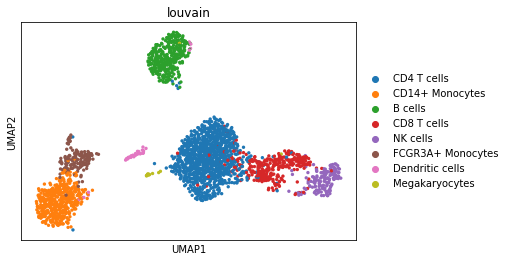

In [5]:
umap_ref = cp.quick_umap(adata_ref)
sc.pl.umap(adata_ref, color = 'louvain')

### Projecting cells onto a reference - `project_cells` function

Finally we can project the target onto the reference data. We provide the respective AnnDatas, specify the cell metadata columns to be transferred, number of nearest neighbors to consider. We also provide the umap_ref to allow fitting the UMAP coordinates.

Finally we specify how categorical labels should be transferred with the `categorical_how` argument. The default (`'mode'`) takes the most prevalent label among nearest neighbors. We will use `'distribution'`, which matches distributions of labels among the nearest neighbors in target/reference, as it performs slightly better.

#### Example

We will fit `adata` onto the `adata_ref` reference landscape. These datasets have been pre-scaled and contain only variable genes. In a real-life scenario we would recommend either using log-normalised data for both datasets or scaling just the reference data and setting `scale_data` to `True`.

In [6]:
cp.project_cells(adata, 
                 adata_ref,
                 obs_columns=['louvain'],
                 k=10,
                 scale_data=False,
                 use_vargenes=False,
                 umap_ref=umap_ref,
                 categorical_how='distribution')

Fitting target data (.X) into reference PC space
Using existing PCA rotation in .varm["PCs"]
Using the provided UMAP reference to fit new data


We can plot the transferred labels (stored as `ref_louvain`) and compare with independent annotation. The data integration looks well with exception for DCs which may be missing from the reference data.

... storing 'ref_louvain' as categorical


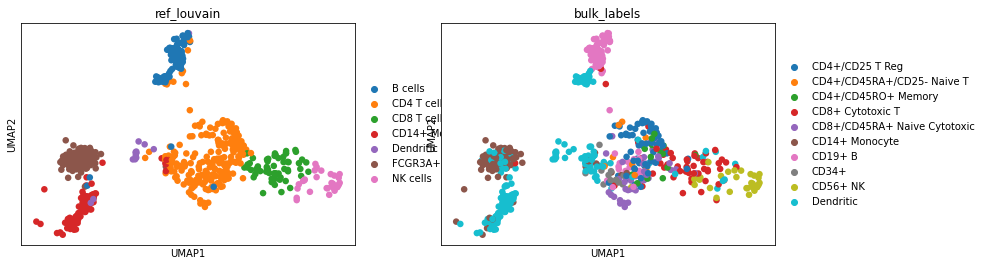

... storing 'louvain' as categorical
... storing 'bulk_labels' as categorical
... storing 'phase' as categorical
... storing 'ref_louvain' as categorical


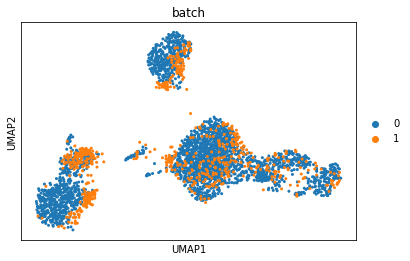

In [7]:
sc.pl.umap(adata, color=['ref_louvain', 'bulk_labels'])
comb = adata_ref.concatenate(adata)
sc.pl.umap(comb, color=['batch'])

### Predicting cells in the reference data - `nnregress()` function

In some cases asymmetric integration is more complicated. Let us consider a scenario, where the original reference landscape was generated after regressing out some unwanted variation (e.g. removing cell cycle effect or performing some other batch correction), so 'corrected data' was the basis of 'corrected PCA' used for clustering and UMAP coordinates.

That 'corrected' space may not be appropriate to directly embed the new data, but `nnregress` can solve this problem if we have a common space to identify the nearest neighbors. This space can be based simply on log-normalised values (if batch effects are not too strong) or generated using another batch correction tool. Once we have established nearest neighbors (with `project_cells`) in the common space we predict target cells in the 'corrected' expression space with `nnregress` (making 'artificial' cells within the reference landscape), which can be easily projected onto the reference landscape.

#### Example

Here we provide a basic demonstration of nnregress use, for a more meaningful example, please have a look at `cellproject_use_case.ipynb` notebook.

We follow from the previous example, where we identified target/reference nearest neighbors. We will generate a new reference landscape, in which we regress out the expression based on `n_genes` to get corrected data, re-calculate PCs and generated a new UMAP.

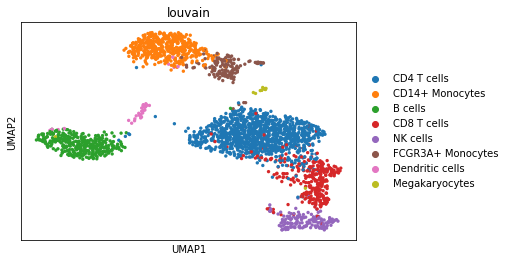

In [8]:
sc.pp.regress_out(adata_ref, keys = 'n_genes')
sc.pp.pca(adata_ref, n_comps = 15)
sc.pp.neighbors(adata_ref, n_neighbors = 10)
umap_ref_regressed = cp.quick_umap(adata_ref)
sc.pl.umap(adata_ref, color = 'louvain')

Now we  predict target cells in the regressed reference space, we will do this for both regressed expression ('X') and newly-derived PC coordinates ('pca'). `nnregress()` will use the previously computed target-reference nearest neighbors (stored in `.uns['cross_nn']`).

In [9]:
cp.nnregress(adata,
             adata_ref,
             regress=['X', 'pca'],
             weighted=True)

Finally, we can project target data back onto the reference landscapes. The PC coordinates are already unified so we don't need to fit them (`fit_pca=False`). We provide the UMAP object based on the regressed data as well.

Using the provided UMAP reference to fit new data


... storing 'ref_louvain' as categorical


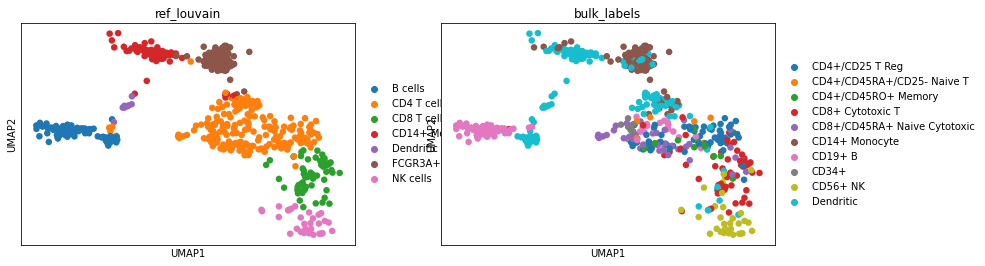

In [10]:
cp.project_cells(adata, 
                 adata_ref,
                 obs_columns=['louvain'],
                 k=10,
                 fit_pca = False,
                 use_vargenes=False,
                 umap_ref=umap_ref_regressed,
                 categorical_how='distribution')
sc.pl.umap(adata, color=['ref_louvain', 'bulk_labels'])

And as a result we have target cells integrated into another space of the reference landscape.